In [1]:
# Import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas.io.sql as sqlio
import psycopg2

from datetime import datetime
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from config_user_dta import config

from sklearn.model_selection import GridSearchCV

In [2]:
# Get the config params
params_ = config()

# Connect to the Postgres_DB:
conn = psycopg2.connect(**params_)

sql = "select * from listings;"
data_df = sqlio.read_sql_query(sql, conn)
data_df.head()

,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,...,elevator,gym,smoking_allowed,accessible,event_suitable,time_since_first_review,time_since_last_review,avg_rating_overall,avg_rating_overall_cat,borough
0,1419,2008-08-08,unknown,unknown,0.0,1.0,1.0,Little Portugal,43.64590,-79.42423,...,0.0,0.0,0.0,0.0,0.0,4+ years,1+ year,5.000000,excellent,West Toronto
1,27423,2010-05-04,within a few hours,100%,0.0,1.0,1.0,South Riverdale,43.66884,-79.32725,...,0.0,0.0,0.0,0.0,0.0,4+ years,1+ year,4.911429,excellent,East Toronto
2,40456,2010-07-20,within an hour,100%,1.0,3.0,1.0,South Parkdale,43.63539,-79.44010,...,0.0,0.0,0.0,0.0,0.0,4+ years,2-6 months,4.727143,excellent,West Toronto
3,43964,2010-08-05,within an hour,100%,0.0,1.0,1.0,Wexford/Maryvale,43.74922,-79.29188,...,0.0,0.0,0.0,0.0,0.0,4+ years,2-8 weeks,4.948571,excellent,Scarborough
4,573892,2012-04-19,within an hour,100%,0.0,6.0,1.0,Waterfront Communities-The Island,43.64278,-79.37985,...,1.0,1.0,0.0,0.0,0.0,4+ years,2-8 weeks,4.845714,excellent,Downtown Toronto


### Preparing the data for modelling

<AxesSubplot:>

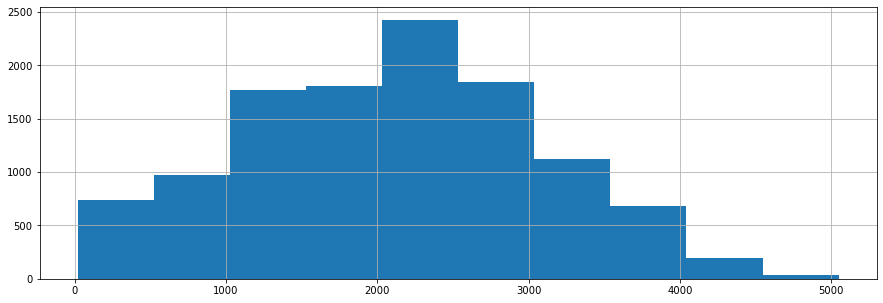

In [3]:
#Checking the host active days column and binning it
data_df.host_active_days.hist(figsize=(15,5))

In [4]:
#Binning
bins=[0, 1094, 1825,2920,3650, 6000]
group_names=["less than 3 years", "3-5 years", "5-8 years","8-10 years","more than 10 years"]
data_df["host_active_days_cat"]= pd.cut(data_df["host_active_days"], bins=bins, labels=group_names, include_lowest=True)

In [5]:
#Total Number of Amenities
col_list=["other_facilities","toiletries", "high_end_electronics","ac_heater","internet",
                "bbq","home_appliances","coffee_machine","long_term_stays","host_greeting","safety","outdoor_space","hot_tub_sauna_or_pool",
              "room_features","private_entrance","parking", "kitchen", "elevator","gym","breakfast","child_friendly",
               "nature_and_views","event_suitable","smoking_allowed","accessible"]
data_df["amenities_sum"]=data_df[col_list].sum(axis=1)

In [6]:
#Create function for multi-collinearity map

def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    #Set the style of the visualization
    sns.set(style="white")
    
    #Create a correlation matrix
    corr=df.corr()
    
    #Generate a mask the size of our covariance matrix
    mask=np.zeros_like(corr,dtype=np.bool)
    mask[np.triu_indices_from(mask)]=True
    
    #Set up the matplotlib figure
    f, ax=plt.subplots(figsize=figsize)
    
    #Generate a custom diverging colormap
    cmap=sns.diverging_palette(220,10, as_cmap=True)
    
    #Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidth=.5, cbar_kws={"shrink":.5}, vmax=corr[corr !=1.0].max().max())

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


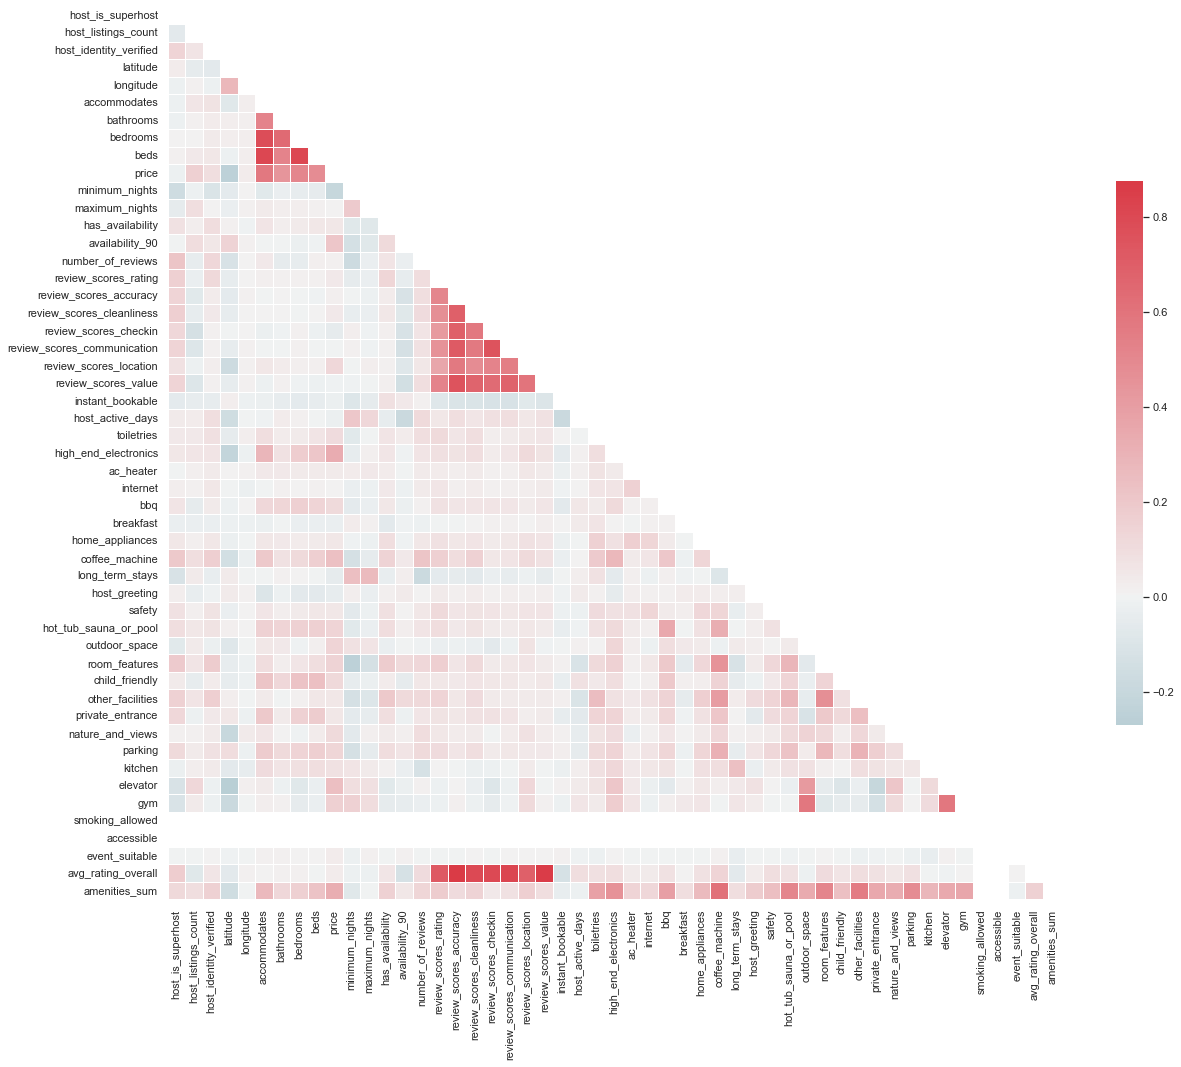

In [7]:
# Check the multi-collinearity for our data
multi_collinearity_heatmap(data_df, figsize=(20,20))

In [8]:
#Drop the columns with high correlation
data_df.drop(columns=["id", "latitude", "longitude","bedrooms","beds","review_scores_rating","review_scores_accuracy","review_scores_communication",
                      "review_scores_location","review_scores_value","room_type","first_review","last_review",
                     "host_since","smoking_allowed","accessible","event_suitable","gym","nature_and_views","review_scores_cleanliness","review_scores_checkin",
                     "other_facilities","toiletries", "high_end_electronics","ac_heater","internet",
                "bbq","home_appliances","coffee_machine","long_term_stays","host_greeting","safety","outdoor_space","hot_tub_sauna_or_pool",
               "room_features","private_entrance","parking", "kitchen", "elevator","gym","breakfast","child_friendly",
             "nature_and_views","event_suitable","time_since_first_review","time_since_last_review"],inplace=True)

In [9]:
# Processng Categorical Features
data_df=pd.get_dummies(data_df,columns=["host_response_time","host_response_rate","borough","property_type","neighbourhood","host_active_days_cat","avg_rating_overall_cat"])

In [10]:
# Create Target and Feature Variables for Machine Learning
X=data_df.drop(["price"], axis=1)
y=data_df["price"]


# #Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state=78)

In [11]:
# Create a PowerTransformer Instance
scaler=PowerTransformer(method='yeo-johnson')

# # #Fit the StandardScaler
X_scaler=scaler.fit(X_train)

# # #Scale the data
X_train_scaled=X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)

### Linear Regression Model

In [12]:
# Run the Linear Regression model
lr_model=LinearRegression()
lr_model.fit(X_train_scaled, y_train)
training_pred=lr_model.predict(X_train_scaled)
predictions=lr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))


RMSE train: 80.427
RMSE test: 79.391
R^2 train: 0.555
R^2 test: 0.550


### Support Vector Regression Model

In [13]:
# Run the Support Vector Regression model
svr_model=SVR(kernel="rbf", C=1.5, epsilon=0.2)
svr_model.fit(X_train_scaled, y_train)
training_pred=svr_model.predict(X_train_scaled)
predictions=svr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 101.333
RMSE test: 100.078
R^2 train: 0.294
R^2 test: 0.284


### GradientBoostingRegressor

In [14]:
# Run the GrdientBoosting Regression model
gbr_model=GradientBoostingRegressor()
gbr_model.fit(X_train_scaled, y_train)
training_pred=gbr_model.predict(X_train_scaled)
predictions=gbr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 67.088
RMSE test: 69.522
R^2 train: 0.690
R^2 test: 0.655


### RandomForestRegressor

In [15]:
# # Run the RandomForest Regression model
rfr_model=RandomForestRegressor()
rfr_model.fit(X_train_scaled, y_train)
training_pred=rfr_model.predict(X_train_scaled)
predictions=rfr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 26.395
RMSE test: 69.168
R^2 train: 0.952
R^2 test: 0.658


### ExtraTreesRegressor

In [16]:
# # Run the ExtraTrees Regression model
etr_model=ExtraTreesRegressor(n_estimators=100,random_state=37)
etr_model.fit(X_train_scaled, y_train)
training_pred=etr_model.predict(X_train_scaled)
predictions=etr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.076
RMSE test: 68.757
R^2 train: 1.000
R^2 test: 0.662


### XGBoostRegressor

In [17]:
# Run the XGBoost Regression model
xgbr_model=xgb.XGBRegressor(max_depth=5, colsample_bytree=0.8, subsample=1.0)
xgbr_model.fit(X_train_scaled, y_train)
training_pred=xgbr_model.predict(X_train_scaled)
predictions=xgbr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 46.833
RMSE test: 68.264
R^2 train: 0.849
R^2 test: 0.667


### GridSearch CV Hyper-parameter Tuning on XGBoost Regressor Model

In [18]:
# Create a function to run XGBRegressor with different parameter and save the best parameters
def grid_search(param_grid, best_param):

    xgb_model = xgb.XGBRegressor(random_state=0, verbosity=1, **best_param)

    grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid,
                               scoring='neg_root_mean_squared_error',
                               )

    best_model = grid_search.fit(X_train_scaled, y_train)
    
    # Save and print the best parameters
    best_param.update(best_model.best_params_)
    print('Optimum parameters', best_param)

In [19]:
# Test optimum values for learning_rate, max_depth, and min_child_weight
best_param = {}
param_grid = {
    'learning_rate':[0.1, 0.5],
    'max_depth':[3, 5, 7, 9],
    'min_child_weight': [1,3,5]
}

grid_search(param_grid,best_param)

Optimum parameters {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1}


In [20]:
# Test optimum values for colsample_bytree, and subsample
param_grid = {
    'colsample_bytree':[0.5,0.6,0.7,0.8],
    'subsample':[0.2, 0.5, 0.8, 1.0]
}

grid_search(param_grid,best_param)

Optimum parameters {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'colsample_bytree': 0.6, 'subsample': 0.8}


In [21]:
# Test optimum values for gamma, reg_alpha. and reg_lambda
param_grid = {
    'gamma':[0.05, 0.5],
    'reg_alpha':[0, 0.5],
    'reg_lambda':[1, 0]
}

grid_search(param_grid,best_param)

Optimum parameters {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'colsample_bytree': 0.6, 'subsample': 0.8, 'gamma': 0.05, 'reg_alpha': 0, 'reg_lambda': 1}


In [22]:
# Test optimum values for param_grid
param_grid = {
    'n_estimators': [100,250,500,1000],
    'eta':[0.05,0.1,0.2]
}

grid_search(param_grid,best_param)

Optimum parameters {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'colsample_bytree': 0.6, 'subsample': 0.8, 'gamma': 0.05, 'reg_alpha': 0, 'reg_lambda': 1, 'eta': 0.05, 'n_estimators': 250}


### Final Model After Hyper-parameter Tuning

In [23]:
# Run the XGBoost Regression model with optimized parameters
model=xgb.XGBRegressor(random_state=0, verbosity=1,**best_param)
model.fit(X_train_scaled, y_train)
training_pred=model.predict(X_train_scaled)
predictions=model.predict(X_test_scaled)
r2_score(y_test,predictions)

# save the model
model.save_model('model.bst')

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 47.058
RMSE test: 67.359
R^2 train: 0.848
R^2 test: 0.676


In [24]:
# Show the top ten feature importances according to the XGBoost Model
ft_weights_xgb_reg = pd.DataFrame(model.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

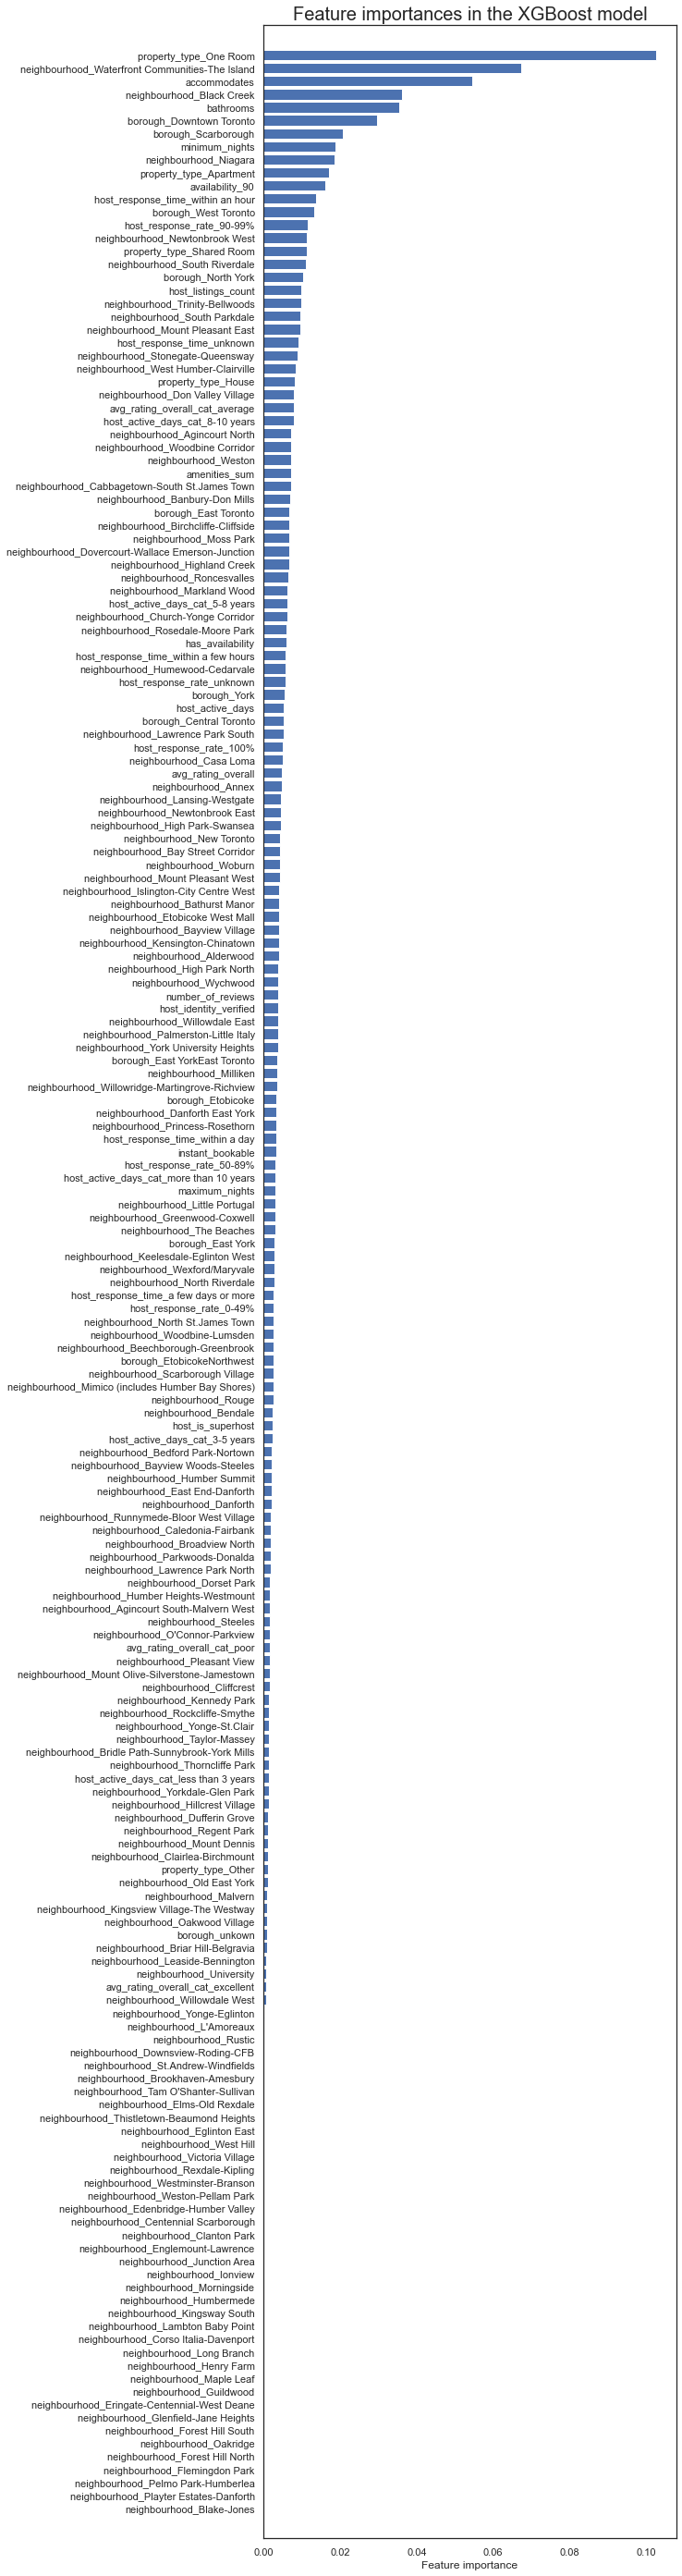

In [25]:
# Plotting feature importances
plt.figure(figsize=(8,50))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=20)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [27]:
for c in data_df.columns:
    print(c)

host_is_superhost
host_listings_count
host_identity_verified
accommodates
bathrooms
price
minimum_nights
maximum_nights
has_availability
availability_90
number_of_reviews
instant_bookable
host_active_days
avg_rating_overall
amenities_sum
host_response_time_a few days or more
host_response_time_unknown
host_response_time_within a day
host_response_time_within a few hours
host_response_time_within an hour
host_response_rate_0-49%
host_response_rate_100%
host_response_rate_50-89%
host_response_rate_90-99%
host_response_rate_unknown
borough_Central Toronto
borough_Downtown Toronto
borough_East Toronto
borough_East York
borough_East YorkEast Toronto
borough_Etobicoke
borough_EtobicokeNorthwest
borough_North York
borough_Scarborough
borough_West Toronto
borough_York
borough_unkown
property_type_Apartment
property_type_House
property_type_One Room
property_type_Other
property_type_Shared Room
neighbourhood_Agincourt North
neighbourhood_Agincourt South-Malvern West
neighbourhood_Alderwood
neig